In [23]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading the Data

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv('/content/drive/MyDrive/Data - Python/Multivariate_pollution.csv')

In [26]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [28]:
#Before we move forward let's make sure that we dont have any null values!

missing_data = df.isnull().sum()
print(missing_data)

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64


In [29]:
#As we saw that the date column type is object, let's convert it to date format

df['date'] = pd.to_datetime(df['date'])

In [30]:
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

In [31]:
df.describe()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,hour,day,month,day_of_week
count,43800,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,2012-07-02 11:30:00,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,11.500000,15.735890,6.526575,2.999452
min,2010-01-02 00:00:00,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2011-04-03 05:45:00,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,5.750000,8.000000,4.000000,1.000000
50%,2012-07-02 11:30:00,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,11.500000,16.000000,7.000000,3.000000
75%,2013-10-01 17:15:00,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,17.250000,23.000000,10.000000,5.000000
max,2014-12-31 23:00:00,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000,23.000000,31.000000,12.000000,6.000000
std,NaN,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247,6.922266,8.795077,3.447092,2.000981


# Visual Exploration and Univariate Analysis

Air pollution is a critical issue affecting urban environments, and accurately forecasting pollution levels can help inform effective policy decisions, early warnings, and public health guidance. To create an effective 1-day-ahead forecast for hourly pollution levels, it is important to understand both temporal dependencies and environmental factors that influence pollution patterns.

This analysis begins by exploring the dataset to uncover temporal relationships and dependencies using statistical techniques and visualizations. Specifically, the focus is on understanding how current pollution levels are influenced by their historical values, which is critical for time series forecasting. Additionally, it’s important to identify the roles played by various meteorological factors and temporal features such as hour of the day and day of the week in shaping pollution trends.

## Data Cleaning

### Outliers Detection

In order to make sure that the model performs well, we have to look at the outliers and handle them.

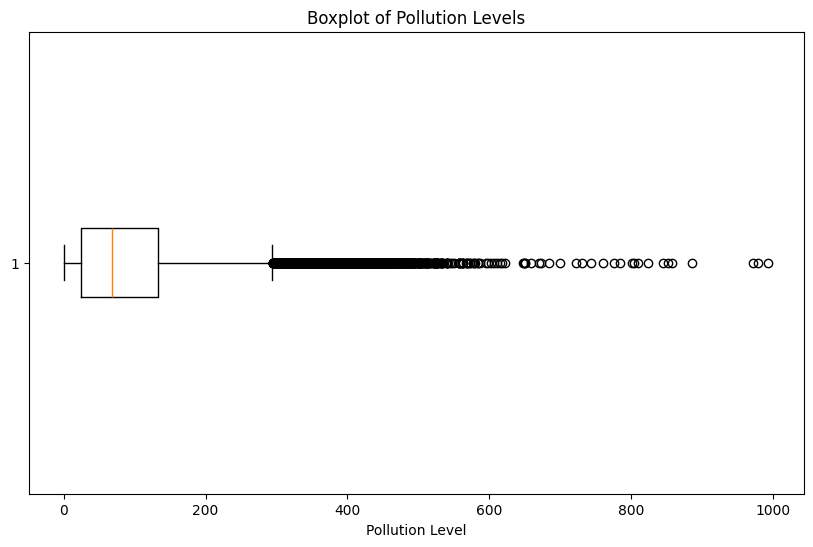

In [32]:
# Plot a boxplot for pollution levels to identify outliers visually
plt.figure(figsize=(10, 6))
plt.boxplot(df['pollution'], vert=False)
plt.title('Boxplot of Pollution Levels')
plt.xlabel('Pollution Level')
plt.show()

The boxplot is showing that there are alot of outliers. We will have to investigate what are the reasons for these outliers. This suggests that the data might be rightly skewed. Let's confirm this:

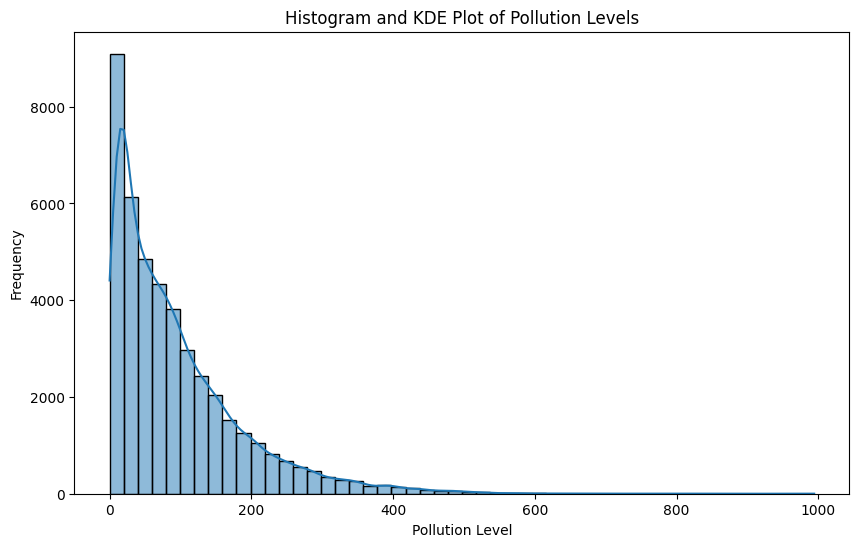

In [33]:
# Plot a histogram and KDE for pollution levels
plt.figure(figsize=(10, 6))
sns.histplot(df['pollution'], kde=True, bins=50)
plt.title('Histogram and KDE Plot of Pollution Levels')
plt.xlabel('Pollution Level')
plt.ylabel('Frequency')
plt.show()

We can clearly see that the data is rightly skewed. This suggests that the data has majority of the values at the lower side. The data is not normally distributed. The occasional spikes are rare but are very significant.

## Data Exploration

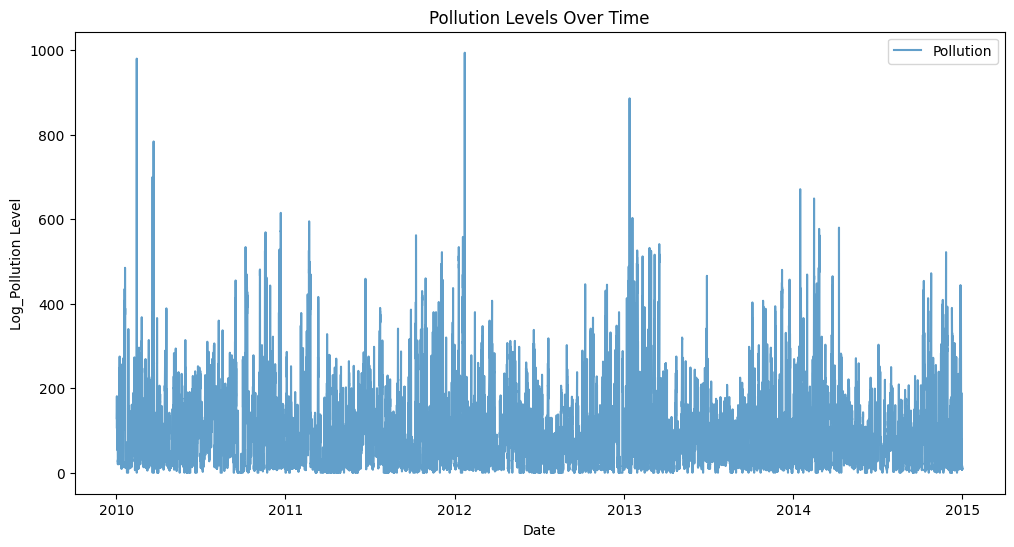

In [34]:
# Plotting Pollution over Time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['pollution'], label='Pollution', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Log_Pollution Level')
plt.title('Pollution Levels Over Time')
plt.legend()
plt.show()

Next let's look at the temperature trends:

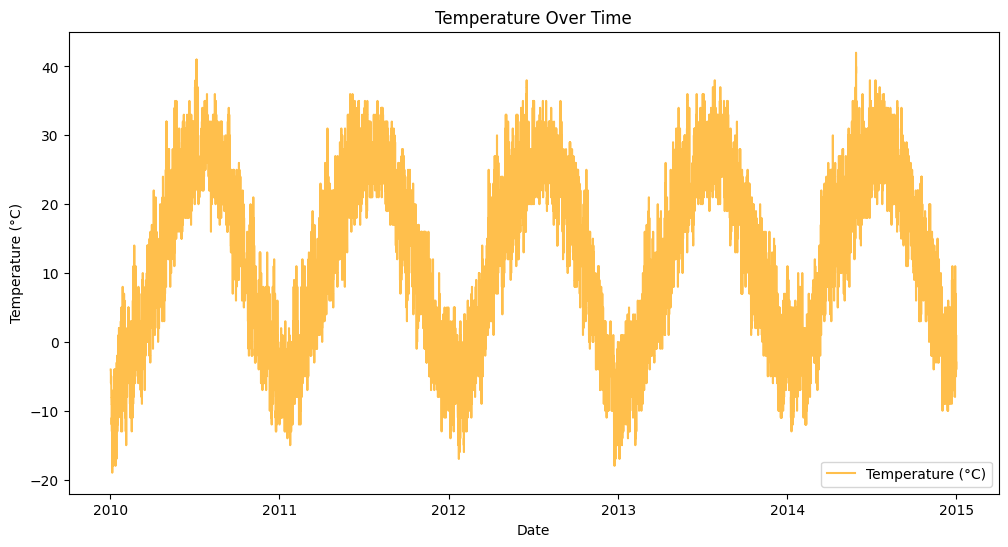

In [35]:
# Plotting Temperature over Time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temp'], label='Temperature (°C)', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()
plt.show()

The graph above gives us the fluctuations in the temperature. The lowest and hightest points in temperature is in correspondance with the seasons. In summers the temperature is high then slowly towards winters the temperrature drops. Other than some exceptions the temperature trends remain constant over the years.



---



### Correlation Matrix

We will now look at relationships between different variables. We will use the correlation matrix and use the heatmap to visualise it.

In [36]:
# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()

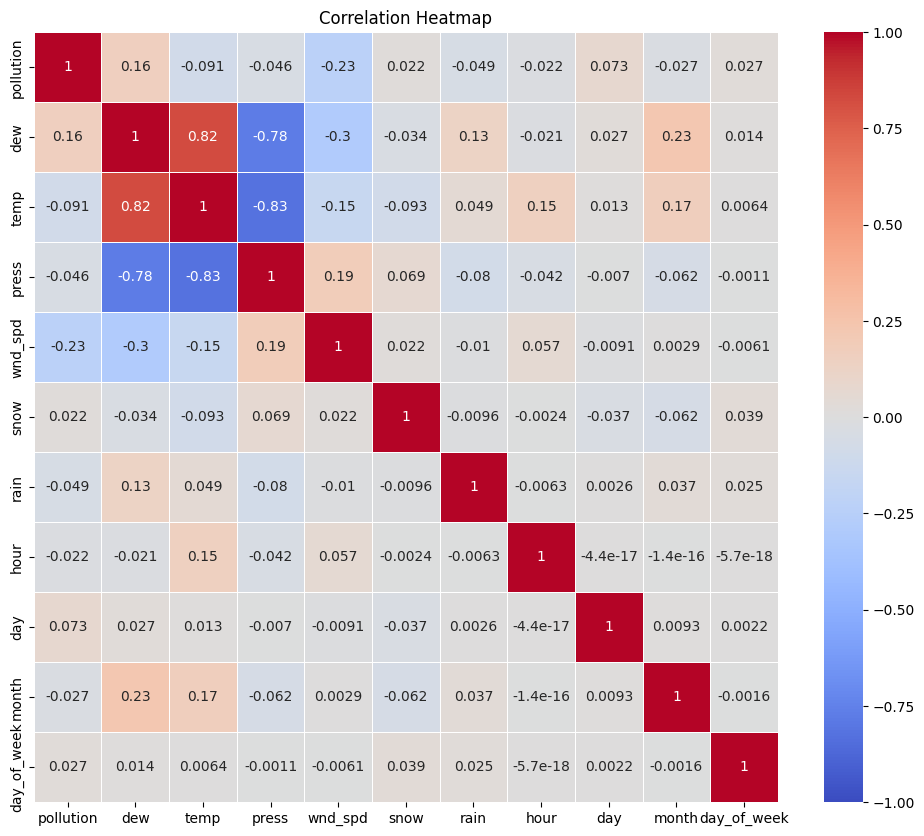

In [37]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Red shows positive correlation and blue shows negative correlation. Positive correlation means that both variables move in the same direction and negative correlation means that both variables move in the opposite direction.

Majority of the variables here have weak corelation other than some exceptions. Which are:


*   Dew has a strong positive correlation with temperature (0.82).
*   Temperature is strongly negatively correlated with pressure (-0.83).

The strong relationships is indicating multicolinearity. Multicolinearity is when two indpendent variables are correlated, as we trying to predict pollution level (dependent variable), the rest are independent variable. This can cause issues as it becomes difficult for a model to determine which of the correlated features is more influential.


---




One thing to observe here that the correlation between temperature and pollution is weak and slightly negative (-0.091). Hence, suggesting that temperature doesn't have a strong influence on pollution.


### Autocorrelation Function (ACF)

We start of with Autocorrelation Function (ACF). Autocorrelation refers to the correlation of a time series with a lagged version of itself, measuring the degree of similarity between observations as a function of time lag [(Investopedia,2024)](https://www.investopedia.com/terms/a/autocorrelation.asp).


---



In our case, we are using ACF to reveal seasonality and periodic dependencies, which are critical for time series forecasting. It will show how pollution levels are correlated with their past values at different time lags.


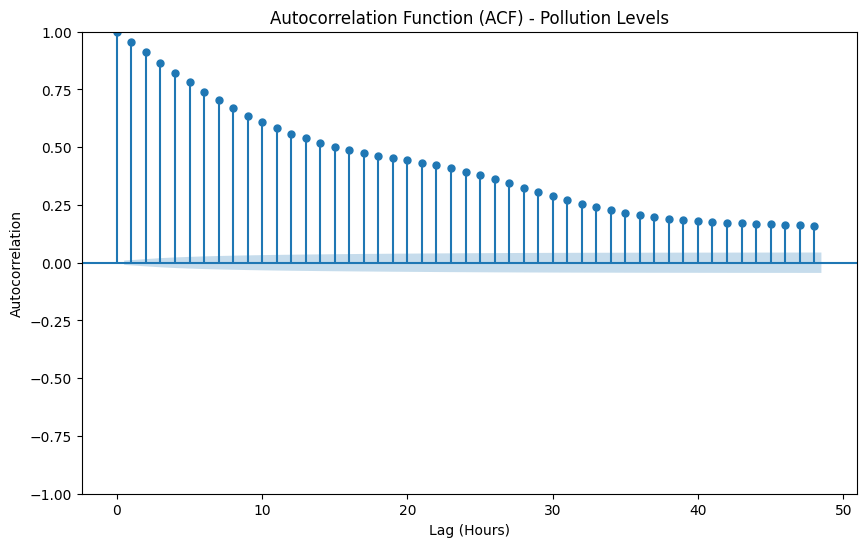

In [38]:
#Autocorrelation Function (ACF) for Pollution Levels
plt.figure(figsize=(10, 6))
plot_acf(df['pollution'], lags=48, ax=plt.gca())  # 48 lags to cover 2 full days (48 hours)
plt.title('Autocorrelation Function (ACF) - Pollution Levels')
plt.xlabel('Lag (Hours)')
plt.ylabel('Autocorrelation')
plt.show()

The ACF plot shows significant autocorrelation at several lag periods, suggesting that past pollution levels have a considerable influence on future values. This is essential for forecasting, as it points out that lagged values are informative for prediction.


---



### Partial Autocorrelation Function (PACF)

The Partial Autocorrelation Function (PACF) is a statistical tool used in time series analysis that quantifies the correlation between a stationary time series and its own lagged values, while controlling for the effects of intervening lags [(Minitab, 2024)](https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/).

This helps in identifying the lag features that are significant for predicting the future pollution level.

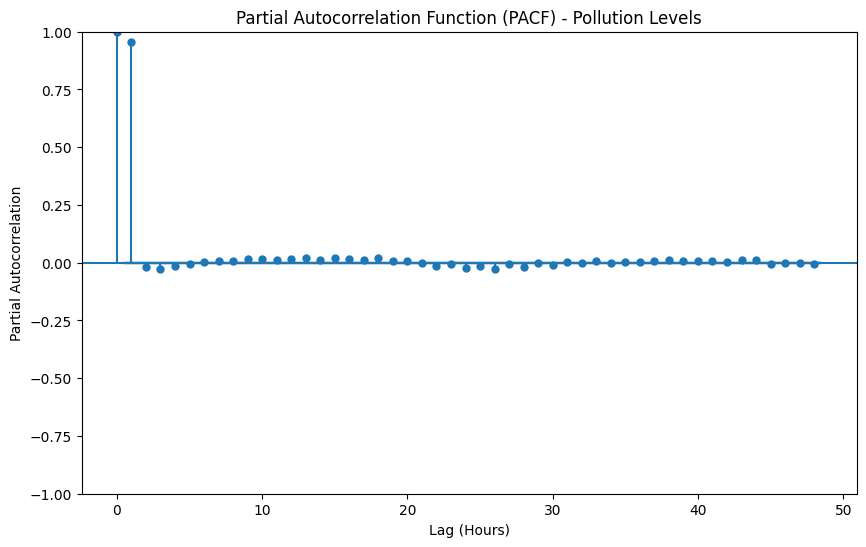

In [39]:
#Partial Autocorrelation Function (PACF) for Pollution Levels
plt.figure(figsize=(10, 6))
plot_pacf(df['pollution'], lags=48, ax=plt.gca())  # 48 lags to cover 2 full days
plt.title('Partial Autocorrelation Function (PACF) - Pollution Levels')
plt.xlabel('Lag (Hours)')
plt.ylabel('Partial Autocorrelation')
plt.show()

The graph here shows us which specific hours in the past have the most influence on the current pollution. This information is useful when deciding how many past hours we should use to predict future pollution levels in our forecasting model.

In our case, we can observe that in lag 1 and 2, pollution level from one and two hour before, has a strong direct influence on the current pollution level.The height of the graph shows how strong the influence is. In the rest of the lags we can see the relationship is not strong enough.

Hence, we can say that pollution from 1 to 2 hours before can help predict the pollution level now. This is very important information for us to include in our model.


---



### Average Pollution by Hour of the Day

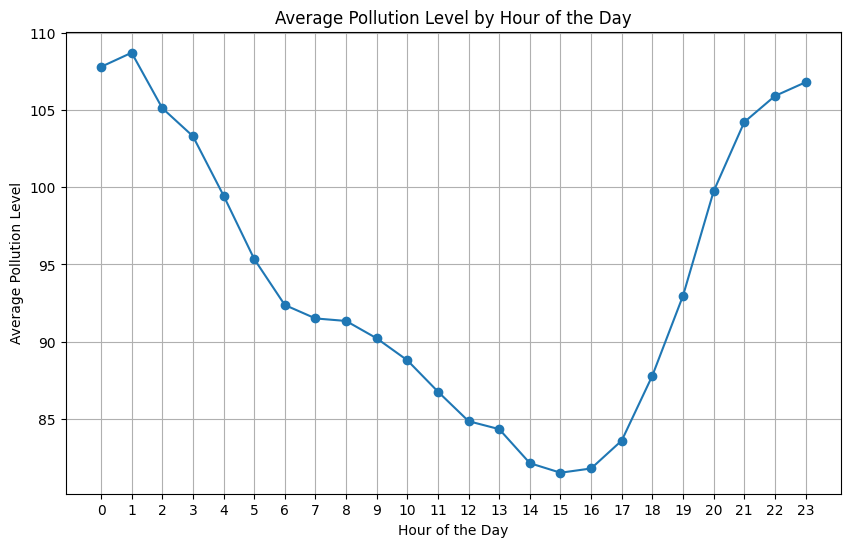

In [40]:
#Average Pollution Levels by Hour of the Day
avg_pollution_hour = df.groupby('hour')['pollution'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_pollution_hour.index, avg_pollution_hour.values, marker='o')
plt.title('Average Pollution Level by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Pollution Level')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.show()

There is a noticeable trend in pollution levels during different times of the day, likely influenced by human activity such as traffic during morning and evening rush hours. Peaks during early and late parts of the day may indicate these trends.



---



### Average Pollution by Day of the Week

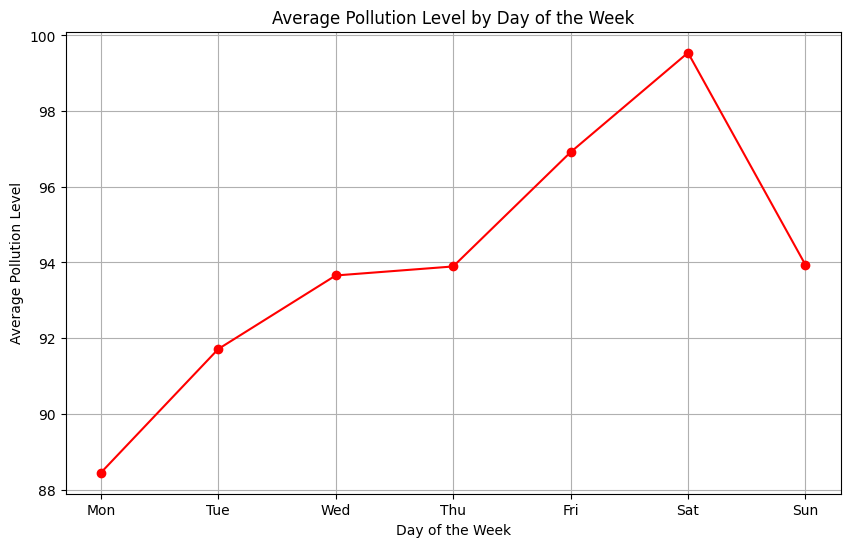

In [41]:
#Average Pollution Levels by Day of the Week
avg_pollution_dayofweek = df.groupby('day_of_week')['pollution'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_pollution_dayofweek.index, avg_pollution_dayofweek.values, marker='o', color='red')
plt.title('Average Pollution Level by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Pollution Level')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

The plot shows variations across the week, with differences between weekdays and weekends that could be linked to lower activity over the weekend.


---



## Model Training

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Define the features (independent variables)
features = df[['dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']]

# Define the target (dependent variable)
target = df['pollution']

# Perform One-Hot Encoding to handle categorical columns
features_encoded = pd.get_dummies(features)

# Train a RandomForest model using the encoded features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_encoded, target)

# Extract feature importances and create a DataFrame to visualize
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features_encoded.columns, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df)

      Feature  Importance
0         dew    0.250887
1        temp    0.235086
3     wnd_spd    0.214841
2       press    0.201690
7  wnd_dir_NW    0.032279
8  wnd_dir_SE    0.017438
6  wnd_dir_NE    0.015558
9  wnd_dir_cv    0.014682
5        rain    0.012621
4        snow    0.004919


In [43]:
#Data preperation

# Log transform the pollution data to reduce skewness
df['pollution_log'] = np.log1p(df['pollution'])   # Using log1p to handle zero values


In [44]:
scaler = MinMaxScaler()

In [45]:
# Keeping only the most important features
selected_features = ['dew', 'day', 'temp', 'month', 'press', 'wnd_spd','pollution', 'pollution_log', 'date']
df_normalized = df[selected_features].copy()

In [46]:
# Adding lagged features to the dataset
def add_lagged_features(df, target_col='pollution', num_lags=2):
    for lag in range(1, num_lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

In [47]:
# Add 2 lagged features to the pollution column
df_normalized = add_lagged_features(df_normalized, target_col='pollution', num_lags=2)

In [48]:
# Drop rows with NaN values (created due to lagging)
df_normalized.dropna(inplace=True)

In [49]:
# Normalizing the features (including lagged features)
features_to_normalize = df_normalized.drop(columns=['pollution', 'pollution_log', 'date']).select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
df_normalized[features_to_normalize] = scaler.fit_transform(df_normalized[features_to_normalize])

df_normalized.head()

,dew,day,temp,month,press,wnd_spd,pollution,pollution_log,date,pollution_lag_1,pollution_lag_2
2,0.426471,0.033333,0.229508,0.0,0.545455,0.005332,159.0,5.075174,2010-01-02 02:00:00,0.148893,0.129779
3,0.485294,0.033333,0.229508,0.0,0.563636,0.008391,181.0,5.204007,2010-01-02 03:00:00,0.159960,0.148893
4,0.485294,0.033333,0.229508,0.0,0.563636,0.009912,138.0,4.934474,2010-01-02 04:00:00,0.182093,0.159960
5,0.485294,0.033333,0.213115,0.0,0.563636,0.011433,109.0,4.700480,2010-01-02 05:00:00,0.138833,0.182093
6,0.485294,0.033333,0.213115,0.0,0.581818,0.014492,105.0,4.663439,2010-01-02 06:00:00,0.109658,0.138833


### Train Test Split

In [50]:
# Normalizing the features (including lagged features)
features_to_normalize = df_normalized.drop(columns=['pollution', 'pollution_log', 'date']).select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
df_normalized[features_to_normalize] = scaler.fit_transform(df_normalized[features_to_normalize])

# Splitting the data into train, validation, and test sets based on date
train_df = df_normalized[df_normalized.date < '2014-01-01']
test_df = df_normalized[df_normalized.date >= '2014-01-01']

# Splitting the training data into training and validation sets (70% for training, 30% for validation)
train_set, validation_set = train_test_split(train_df, test_size=0.3, shuffle=False)

# Define features and target for training set
train_X = train_set.drop(columns=['pollution', 'pollution_log', 'date'])
train_y = train_set['pollution_log']

# Define features and target for validation set
validation_X = validation_set.drop(columns=['pollution', 'pollution_log', 'date'])
validation_y = validation_set['pollution_log']

# Define features and target for the test set
test_X = test_df.drop(columns=['pollution', 'pollution_log', 'date'])
test_y = test_df['pollution_log']

# Drop datetime columns if they are still present, and retain only numeric columns
train_X = train_X.select_dtypes(include=[np.number])
validation_X = validation_X.select_dtypes(include=[np.number])
test_X = test_X.select_dtypes(include=[np.number])

### Sequences

In [51]:
# Define a function to create sequences for RNN with lagged features
def create_sequences(X, y, time_steps=24):
    X_sequences, y_sequences = [], []
    for i in range(len(X) - time_steps):
        X_sequences.append(X.iloc[i:i + time_steps].values.astype(np.float32))
        y_sequences.append(y.iloc[i + time_steps].astype(np.float32))
    return np.array(X_sequences), np.array(y_sequences)

In [56]:
# Make sure your data is reshaped as (samples, time_steps, features) before feeding it into the model
time_steps = 24
train_X_seq, train_y_seq = create_sequences(train_X, train_y, time_steps=24)
validation_X_seq, validation_y_seq = create_sequences(validation_X, validation_y, time_steps=24)
test_X_seq, test_y_seq = create_sequences(test_X, test_y, time_steps=24)

### Define and Training the Model

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam

In [57]:
# Define the GRU model
model = Sequential()

# Add the first GRU layer (equivalent to LSTM)
model.add(GRU(units=75, return_sequences=True, input_shape=(time_steps, train_X_seq.shape[2])))
model.add(Dropout(0.4))

# Add the second GRU layer
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.4))

# Add the output layer
model.add(Dense(units=1))  # Output layer (for regression, single unit)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Set up ModelCheckpoint and EarlyStopping callbacks
checkpoint_filepath = 'best_model_gru.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Train the model with callbacks
epochs = 25
batch_size = 32
history = model.fit(train_X_seq, train_y_seq,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_X_seq, validation_y_seq),
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.1264
Epoch 1: val_loss improved from inf to 0.97450, saving model to best_model_gru.keras
766/766 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 6.1228 - val_loss: 0.9745
Epoch 2/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.6183
Epoch 2: val_loss improved from 0.97450 to 0.79337, saving model to best_model_gru.keras
766/766 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 1.6182 - val_loss: 0.7934
Epoch 3/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3929
Epoch 3: val_loss improved from 0.79337 to 0.66788, saving model to best_model_gru.keras
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 1.3928 - val_loss: 0.6679
Epoch 4/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2259
Epoch 4: val_loss improved from 0.66788 to 0.55727, saving model to best_model_gru.keras
766/766 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 1.2258 - val_loss: 0.5573
Epoch 5/25
765/766 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9986


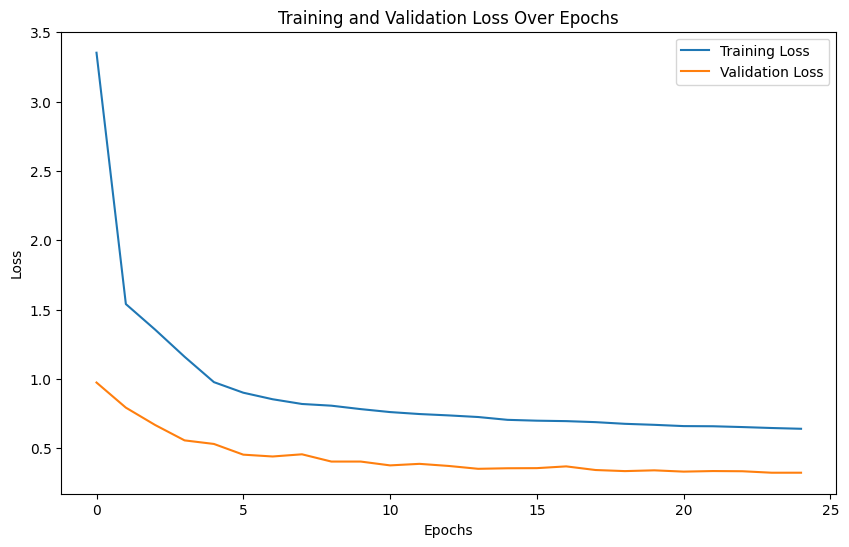

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# Generate predictions for the validation set
validation_predictions = model.predict(validation_X_seq)

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(validation_y_seq, validation_predictions)
rmse = mean_squared_error(validation_y_seq, validation_predictions, squared=False)  # Root Mean Squared Error (RMSE)
mae = mean_absolute_error(validation_y_seq, validation_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 0.3241
Root Mean Squared Error (RMSE): 0.5693
Mean Absolute Error (MAE): 0.3331


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


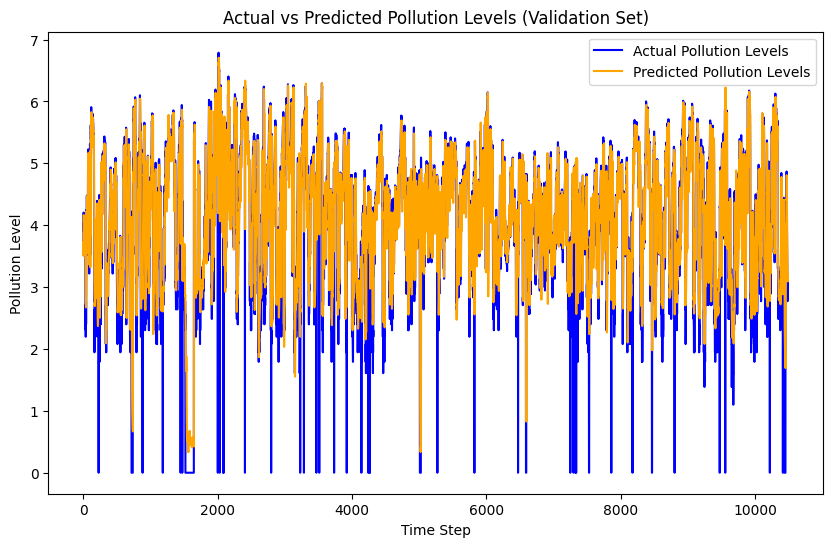

In [62]:
# Plot actual vs predicted values for validation set
plt.figure(figsize=(10, 6))
plt.plot(validation_y_seq, label='Actual Pollution Levels', color='blue')
plt.plot(validation_predictions, label='Predicted Pollution Levels', color='orange')
plt.title('Actual vs Predicted Pollution Levels (Validation Set)')
plt.xlabel('Time Step')
plt.ylabel('Pollution Level')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import r2_score
r2 = r2_score(validation_y_seq, validation_predictions)
print(f"R-Squared (R²): {r2:.4f}")

R-Squared (R²): 0.7676


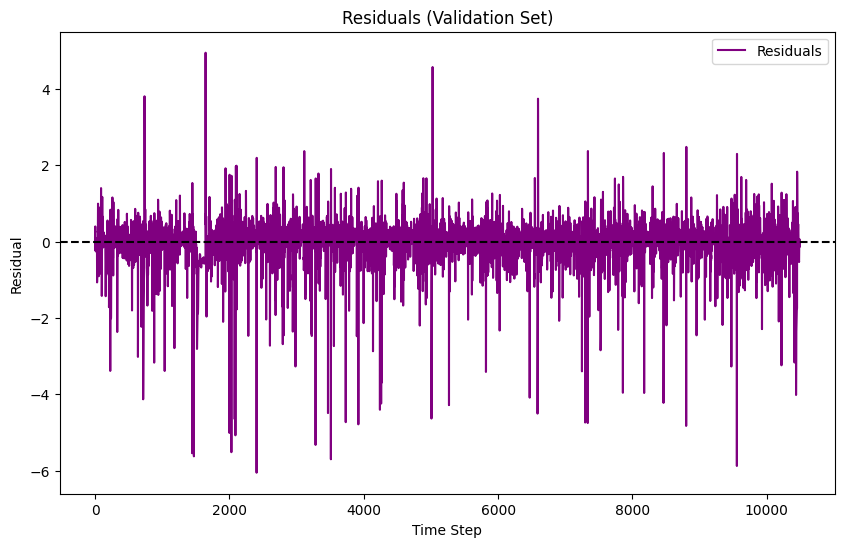

In [64]:
# Calculate residuals
residuals = validation_y_seq - validation_predictions.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals (Validation Set)')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.legend()
plt.show()

### Baseline Model